In [2]:
#@title Imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import os
import string

In [5]:
#@title Reading the text data file
allowed_chars = string.ascii_letters + '\n' + ' ' + string.punctuation
data = ''
with open('/content/limerick_dataset.txt', mode="r", encoding="utf8") as f:
    for line in f:
        if line != '\n':
            data += ''.join(c for c in line if c in allowed_chars)

vocab = sorted(set(data))
chars = tf.strings.unicode_split(data, input_encoding='UTF-8')

print(f'Total number of chraceters: {len(data):,}')
print(f'Numnber of unique characters: {len(vocab):,}\n')
print(data[:148], '\n')
print(vocab, '\n')
print(chars)

Total number of chraceters: 16,195,880
Numnber of unique characters: 85

The very first word here is a.
It's used with a noun to convey
A singular notion
Like "a duck" or "a potion"
Or top notch as when used in "Grade A." 

['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~'] 

tf.Tensor([b'T' b'h' b'e' ... b'.' b'"' b'\n'], shape=(16195880,), dtype=string)


In [6]:
rhymes = defaultdict(lambda: defaultdict(lambda: 0))

lines = data.split('\n')

for i in range(len(lines)-1):
    line = lines[i]
    # if i%5 == 0:
    #     rhymes[line[-3:]][lines[i+1][-3:]] += 1
    #     rhymes[line[-3:]][lines[i+4][-3:]] += 1
    # if i%5 == 1:
    #     rhymes[line[-3:]][lines[i-1][-3:]] += 1
    #     rhymes[line[-3:]][lines[i+3][-3:]] += 1
    # if i%5 == 2:
    #     rhymes[line[-3:]][lines[i+1][-3:]] += 1
    # if i%5 == 3:
    #     rhymes[line[-3:]][lines[i-1][-3:]] += 1
    # if i%5 == 4:
    #     rhymes[line[-3:]][lines[i-4][-3:]] += 1
    #     rhymes[line[-3:]][lines[i-3][-3:]] += 1
    val = lines[i+1].split(' ')[-1]
    if val != '' and val != '\n':
        rhymes[line[-3:]][val] += 1


for idx, (key, val) in enumerate(rhymes.items()):
    if idx == 10:
        break
    print(f'{key}: {val}')

 a.: defaultdict(<function <lambda>.<locals>.<lambda> at 0x7e3dc0e9f250>, {'convey': 1, 'write': 1, 'token': 1, 'pursue': 1, "'n'": 1})
vey: defaultdict(<function <lambda>.<locals>.<lambda> at 0x7e3dc0e9f2e0>, {'notion': 1, 'clover.': 1, '"A")': 1, 'decay.': 1, 'outr)': 1, 'about': 1, 'B.C.E."': 1, 'pray:': 1, 'Navy)': 1, 'astray.': 1, 'tools.': 1, 'ivy),': 1, 'may': 2, 'say,': 2, 'shared': 1, 'defining': 1, 'line."': 1, 'Today.': 1, 'outmanned!': 1, 'need': 1, 'today': 2, 'rankled': 1, 'say': 4, 'away.': 3, 'wit,': 1, 'support.': 1, 'bouquet.': 1, 'A-OK.': 1, 'pay,': 1, 'delay!").': 1, 'me;': 1, 'gloom': 1, 'say.': 1, 'hey,': 1, 'tight.': 1, 'day,': 2, 'suggestion,': 1, 'day': 1, 'okay.': 1, 'parfait!': 1, 'way,': 1, 'stay."': 1, 'inherently,': 1, 'display.': 1, 'today?"': 1, 'crude': 1, 'warning': 1, 'They': 1, 'today.': 1, 'seen': 1, 'OK?': 1, 'today,': 1, 'cheese': 1, 'speak.': 1})
ion: defaultdict(<function <lambda>.<locals>.<lambda> at 0x7e3dc0e9f370>, {'potion"': 1, 'animadversi

In [9]:
#@title Data preprocessing
# create a lookup table to store indices for each char
ids_from_chars = tf.keras.layers.StringLookup(vocabulary=list(vocab), mask_token=None)
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(),
    invert=True,
    mask_token=None
)

def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

all_ids = ids_from_chars(chars)
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

# for ids in ids_dataset.take(148):
#     if chars_from_ids(ids).numpy().decode('utf-8') == '\n':
#         print()
#     else:
#         print(ids.numpy(), end=' ')
# print('\n')
# for ids in ids_dataset.take(148):
#     print(chars_from_ids(ids).numpy().decode('utf-8'), end='')
# print('\n')

seq_length = 150
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

# for seq in sequences.take(1):
#     print(chars_from_ids(seq))
# print()
# for seq in sequences.take(1):
#     print(text_from_ids(seq).numpy())

def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'The very first word here is a.\nIt\'s used with a noun to convey\nA singular notion\nLike "a duck" or "a potion"\nOr top notch as when used in "Grade A."\n"'
Target: b'he very first word here is a.\nIt\'s used with a noun to convey\nA singular notion\nLike "a duck" or "a potion"\nOr top notch as when used in "Grade A."\n"I'


In [10]:
#@title Train, Validation, Test split
BUFFER_SIZE = len(data)
# Define the size of the train, validation, and test sets
TRAIN_SIZE = 0.8
VAL_SIZE = 0.1
TEST_SIZE = 0.1
# Total number of character IDs
num_samples = len(dataset)
# Calculate the number of examples to include in each set
train_size = int(TRAIN_SIZE * num_samples)
val_size = int(VAL_SIZE * num_samples)
test_size = int(TEST_SIZE * num_samples)
# Shuffle the dataset
dataset = dataset.shuffle(BUFFER_SIZE)
# Split the dataset into train, validation, and test sets
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size).take(test_size)

# batch the dataset
BATCH_SIZE = 64
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)
# Prefetch the datasets
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [11]:
#@title Define the model
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())
# The embedding dimension
embedding_dim = 512
# Number of RNN units
rnn_units = 512

class LSTM(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__(self)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(
            units=rnn_units,
            return_sequences=True,
            return_state=True
        )
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, states=None, return_state=False, training=False):
        x = inputs
        x = self.embedding(x, training=training)
        if states is None:
            states = self.lstm.get_initial_state(x)
        x, state_h, state_c = self.lstm(x, initial_state=states, training=training)
        states = [state_h, state_c]
        x = self.dense(x, training=training)

        if return_state:
            return x, states
        else:
            return x

In [13]:
#@title Compile the model
lstm_model = LSTM(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units
)
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
LEARNING_RATE = 1e-3
lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=loss,
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(),
    ]
)

# checkpoints to continue training after stopping
checkpoint_path = "./training_checkpoints/cp.ckpt"
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    verbose=0
)
# early stopping callback
PATIENCE = 3
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=PATIENCE, restore_best_weights=True)

In [15]:
#@title Train the model
EPOCHS = 30
# start training your model
history = lstm_model.fit(
    x=train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/30
1340/1340 [==============================] - 114s 65ms/step - loss: 1.7622 - sparse_categorical_accuracy: 0.4651 - val_loss: 1.6552 - val_sparse_categorical_accuracy: 0.4939
Epoch 2/30
1340/1340 [==============================] - 114s 66ms/step - loss: 1.6072 - sparse_categorical_accuracy: 0.5072 - val_loss: 1.5647 - val_sparse_categorical_accuracy: 0.5192
Epoch 3/30
1340/1340 [==============================] - 115s 66ms/step - loss: 1.5423 - sparse_categorical_accuracy: 0.5248 - val_loss: 1.5131 - val_sparse_categorical_accuracy: 0.5328
Epoch 4/30
1340/1340 [==============================] - 119s 65ms/step - loss: 1.5040 - sparse_categorical_accuracy: 0.5353 - val_loss: 1.4873 - val_sparse_categorical_accuracy: 0.5397
Epoch 5/30
1340/1340 [==============================] - 126s 75ms/step - loss: 1.4780 - sparse_categorical_accuracy: 0.5425 - val_loss: 1.4626 - val_sparse_categorical_accuracy: 0.5469
Epoch 6/30
1340/1340 [==============================] - 126s 75ms/step - lo

Train loss: 1.76, 1.61, 1.54, 1.50, 1.48, 1.46, 1.44, 1.43, 1.42, 1.41, 1.40, 1.40, 1.39, 1.39, 1.38, 1.38, 1.37, 1.37, 1.37, 1.36, 1.36, 1.36, 1.36, 1.35, 1.35, 1.35, 1.35, 1.34, 1.34, 1.34, 
Val loss: 1.66, 1.56, 1.51, 1.49, 1.46, 1.45, 1.43, 1.42, 1.41, 1.40, 1.39, 1.39, 1.38, 1.37, 1.37, 1.37, 1.37, 1.36, 1.36, 1.35, 1.35, 1.35, 1.34, 1.34, 1.34, 1.34, 1.34, 1.34, 1.34, 1.33, 
Train PPL: 5.82, 4.99, 4.68, 4.50, 4.38, 4.30, 4.23, 4.18, 4.14, 4.10, 4.07, 4.04, 4.02, 4.00, 3.98, 3.96, 3.95, 3.93, 3.92, 3.91, 3.90, 3.89, 3.88, 3.87, 3.86, 3.85, 3.84, 3.84, 3.83, 3.82, 
Val PPL: 5.23, 4.78, 4.54, 4.43, 4.32, 4.25, 4.17, 4.12, 4.08, 4.07, 4.03, 4.00, 3.98, 3.95, 3.94, 3.93, 3.92, 3.90, 3.88, 3.88, 3.85, 3.85, 3.83, 3.83, 3.83, 3.82, 3.81, 3.80, 3.82, 3.80, 
Batch_size: 64, Learning_ate: 0.001, RNN_units: 256, Embedding_size: 256, Epochs: 30
Final_train_loss: 1.3415
Final_validation_loss: 1.3346



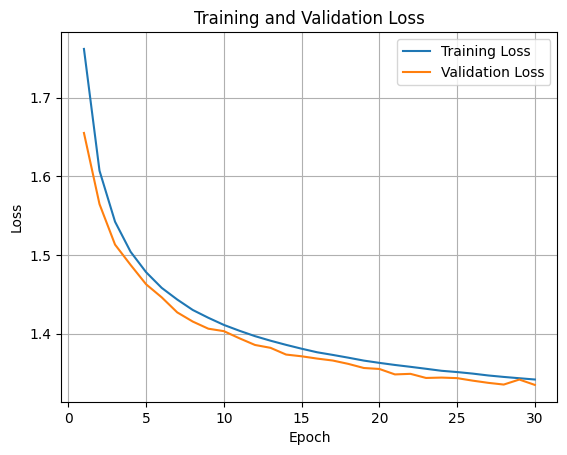

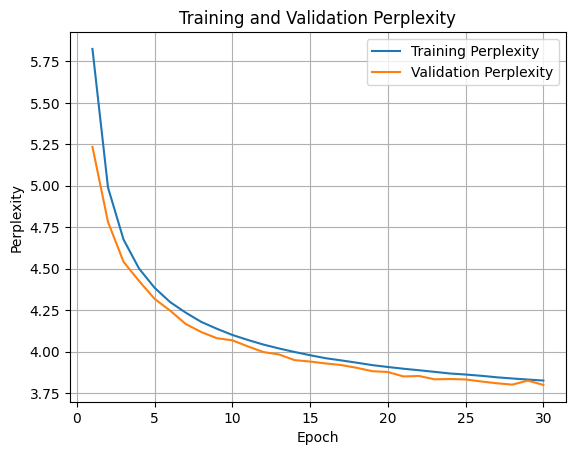

In [19]:
#@title Plot
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_ppl = np.exp(train_loss)
val_ppl = np.exp(val_loss)
print('Train loss: ', end='')
for elem in train_loss:
    print(f'{elem:.2f}', end=', ')
print()
print('Val loss: ', end='')
for elem in val_loss:
    print(f'{elem:.2f}', end=', ')
print()
print('Train PPL: ', end='')
for elem in train_ppl:
    print(f'{elem:.2f}', end=', ')
print()
print('Val PPL: ', end='')
for elem in val_ppl:
    print(f'{elem:.2f}', end=', ')
print()
# print(f"Batch_size: {64}, Learning_ate: {1e-3}, RNN_units: {256}, Embedding_size: {256}, Epochs: {early_stopping_cb.stopped_epoch-PATIENCE+1}")
# print(f"Train_loss: {train_loss[early_stopping_cb.stopped_epoch-PATIENCE]}")
# print(f"Validation_loss: {val_loss[early_stopping_cb.stopped_epoch-PATIENCE]}\n")
print(f"Batch_size: {64}, Learning_ate: {1e-3}, RNN_units: {256}, Embedding_size: {256}, Epochs: {EPOCHS}")
print(f"Final_train_loss: {train_loss[-1]:.4f}")
print(f"Final_validation_loss: {val_loss[-1]:.4f}\n")

def plot(num_epochs, train_loss, val_loss, title):
    title = title.lower().capitalize()
    epochs = [i for i in range(1, num_epochs + 1)]
    plt.plot(epochs, train_loss, label=f'Training {title}')
    plt.plot(epochs, val_loss, label=f'Validation {title}')
    plt.title(f'Training and Validation {title}')
    plt.xlabel('Epoch')
    plt.ylabel(f'{title}')
    plt.legend()
    plt.grid(True)
    plt.show()

plot(len(train_loss), train_loss, val_loss, title='loss')
print()
plot(len(train_ppl), train_ppl, val_ppl, title='perplexity')

In [17]:
!zip -r /content/training_checkpoints.zip /content/training_checkpoints/

  adding: content/training_checkpoints/ (stored 0%)
  adding: content/training_checkpoints/cp.ckpt.index (deflated 59%)
  adding: content/training_checkpoints/cp.ckpt.data-00000-of-00001 (deflated 7%)
  adding: content/training_checkpoints/checkpoint (deflated 38%)


In [18]:
from google.colab import files
files.download("/content/training_checkpoints.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
#@title Load a pre-trained model
model = LSTM(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units
)
model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True))
# Loads the weights
model.load_weights(checkpoint_path)
# Evaluate the model
eval_loss = model.evaluate(test_dataset, verbose=1)
print("Restored model loss: {:.4f}".format(eval_loss))

167/167 [==============================] - 30s 17ms/step - loss: 1.3307
Restored model loss: 1.3307


In [22]:
#@title Inference
class OneStep(tf.keras.Model):
    def __init__(self, model, chars_from_ids, ids_from_chars, rhymes, temperature=1.0):
        super().__init__()
        self.temperature = temperature
        self.model = model
        self.chars_from_ids = chars_from_ids
        self.ids_from_chars = ids_from_chars
        self.rhymes = rhymes

        # Create a mask to prevent "[UNK]" from being generated.
        skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
        sparse_mask = tf.SparseTensor(
            # Put a -inf at each bad index.
            values=[-float('inf')]*len(skip_ids),
            indices=skip_ids,
            # Match the shape to the vocabulary
            dense_shape=[len(ids_from_chars.get_vocabulary())]
        )
        self.prediction_mask = tf.sparse.to_dense(sparse_mask)

    @tf.function
    def generate_one_step(self, inputs, states=None):
        # Convert strings to token IDs.
        input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
        input_ids = self.ids_from_chars(input_chars).to_tensor()

        predicted_logits, states = self.model(inputs=input_ids, states=states, return_state=True)
        # Only use the last prediction.
        predicted_logits = predicted_logits[:, -1, :]
        predicted_logits = predicted_logits/self.temperature
        # Apply the prediction mask: prevent "[UNK]" from being generated.
        predicted_logits = predicted_logits + self.prediction_mask

        return predicted_logits, states

    def beam_search(self, start_sequence, beam_width, num_lines=5):
        candidates = [(start_sequence, tf.zeros(()))]
        final_candidates = []
        end_token = "\n"
        states = None

        # generate the first line
        while len(final_candidates) < num_lines:
            all_expansions = []

            for sequence, likelihood in candidates:
                seq = sequence.numpy()[0].decode("utf-8") #current sequence
                if seq[-1] == end_token or len(seq) >= 100:
                    final_candidates.append((sequence, likelihood))
                    continue

                output_probabilities, states = self.generate_one_step(sequence, states=states) #change states
                output_probabilities = np.squeeze(output_probabilities, axis=0)

                # softmax + log likelihood
                output_probabilities = tf.nn.softmax(output_probabilities)
                output_probabilities = tf.math.log(output_probabilities)

                # Select top-k next steps based on probabilities
                top_k_indices = np.argsort(-output_probabilities)[:beam_width]
                top_k_probs = [output_probabilities[x] for x in top_k_indices]

                for next_token_idx, next_token_prob in zip(top_k_indices, top_k_probs):
                    new_sequence = sequence + self.chars_from_ids(next_token_idx)
                    new_likelihood = likelihood + next_token_prob
                    all_expansions.append((new_sequence, new_likelihood))

            # Sort all_expansions by likelihood in descending order
            all_expansions.sort(key=lambda x: x[1], reverse=True)

            # Keep only the top beam_width sequences
            candidates = all_expansions[:beam_width]

        # for elem in final_candidates:
        #     print(elem[0])
        # print()

        # reset to preapre for the next n-1 lines
        candidates = final_candidates
        final_candidates = []
        rhyme_count = 1

        # generate next n-1 lines
        for i in range(1, num_lines):
            while len(final_candidates) < num_lines:
                all_expansions = []

                for sequence, likelihood in candidates:
                    seq = sequence.numpy()[0].decode("utf-8") #current sequence
                    if seq.count(end_token) >= i+1 or len(seq) >= 100*i:
                        # find the pre-last newline position
                        pos = seq.rfind('\n', 0, -2)
                        # construct the rhyme
                        last_three = seq[pos-3:pos]
                        rhyme_match = ''
                        if len(self.rhymes[last_three]) > 0 and rhyme_count > 0:
                            rhyme_match = max(self.rhymes[last_three], key=self.rhymes[last_three].get)
                            # seq = seq[:-4] + '###'+rhyme_match+'###'+'\n'
                            seq = seq.split(' ')
                            seq = seq[:-1] + [rhyme_match]
                            seq = ' '.join(seq) + '\n'
                            seq = seq.encode('utf-8')
                            seq = tf.constant([seq])
                            final_candidates.append((seq, likelihood))
                        else:
                            final_candidates.append((sequence, likelihood))

                        if rhyme_count == 2:
                            rhyme_count = 0
                        else:
                            rhyme_count += 1

                        continue

                    output_probabilities, states = self.generate_one_step(sequence, states=states) #change states
                    output_probabilities = np.squeeze(output_probabilities, axis=0)

                    # softmax + log likelihood
                    output_probabilities = tf.nn.softmax(output_probabilities)
                    output_probabilities = tf.math.log(output_probabilities)

                    # Select top-k next steps based on probabilities
                    top_k_indices = np.argsort(-output_probabilities)[:beam_width]
                    top_k_probs = [output_probabilities[x] for x in top_k_indices]

                    for next_token_idx, next_token_prob in zip(top_k_indices, top_k_probs):
                        new_sequence = sequence + self.chars_from_ids(next_token_idx)
                        new_likelihood = likelihood + next_token_prob
                        all_expansions.append((new_sequence, new_likelihood))

                # Sort all_expansions by likelihood in descending order
                all_expansions.sort(key=lambda x: x[1], reverse=True)

                # Keep only the top beam_width sequences
                candidates = all_expansions[:beam_width]

            # for elem in final_candidates:
            #     print(elem[0])
            # print()
            if i < num_lines-1:
                # reset to preapre for the next n-i lines
                candidates = final_candidates
                final_candidates = []

        # final_candidates.sort(key=lambda x: x[1], reverse=True)

        final_seq = final_candidates[0][0].numpy()[0].decode("utf-8")
        max_score = len(final_candidates[0][0].numpy()[0].decode("utf-8"))/final_candidates[0][1]
        for seq, prob in final_candidates:
            seq = seq.numpy()[0].decode("utf-8")
            prob = prob
            score = len(seq)/prob
            if score < max_score:
                max_score = score
                final_seq = seq

        return final_seq

In [25]:
one_step_model = OneStep(lstm_model, chars_from_ids, ids_from_chars, rhymes)
s = one_step_model.beam_search(tf.constant(['the very first ']), 5)
# print('\n')
# print('-'*50)
print(s)

the very first day.
That's the place that you've say,
That you'll find that you'll day.
You'll be found in your head to your say,
But you'll find that you'll day.



In [10]:
#@title Hyperparameter tuning
EPOCHS = 5
# PATIENCE = 5
config_arr = []

# define loss
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
# reset the dataset
seq_length = 150
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)
dataset = sequences.map(split_input_target)
BUFFER_SIZE = len(data)
# Define the size of the train, validation, and test sets
TRAIN_SIZE = 0.8
VAL_SIZE = 0.1
TEST_SIZE = 0.1
# Total number of character IDs
num_samples = len(dataset)
# Calculate the number of examples to include in each set
train_size = int(TRAIN_SIZE * num_samples)
val_size = int(VAL_SIZE * num_samples)
test_size = int(TEST_SIZE * num_samples)
# Shuffle the dataset
dataset = dataset.shuffle(BUFFER_SIZE)
# Split the dataset into train, validation, and test sets
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size).take(test_size)
# write output to a file
f = open('/content/hyperparam_tuning.txt', 'w')

for bs in [64]:
    # batch the dataset
    train_dataset = train_dataset.batch(bs, drop_remainder=True)
    val_dataset = val_dataset.batch(bs, drop_remainder=True)
    test_dataset = test_dataset.batch(bs, drop_remainder=True)
    # Prefetch the datasets
    train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
    val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

    for lr in [1e-4, 1e-3, 1e-2]:
        for hs in [128, 256, 512]:
            for ed in [128, 256, 512]:
                # initialize the model
                model = LSTM(vocab_size=vocab_size, embedding_dim=ed, rnn_units=hs)
                model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss)
                # train the model
                history = model.fit(
                    x=train_dataset,
                    epochs=EPOCHS,
                    validation_data=val_dataset,
                    verbose=1,
                )
                # print the best configuration
                train_loss = history.history["loss"]
                val_loss = history.history["val_loss"]
                config_arr.append((bs, lr, hs, ed, EPOCHS, train_loss[-1], val_loss[-1]))
                print(f"\nBatch_size: {bs}, Learning_rate: {lr}, Hidden_size: {hs}, Embedding_size: {ed}, Epochs: {EPOCHS}")
                print(f"Train_loss: {train_loss[-1]:.4f}")
                print(f"Validation_loss: {val_loss[-1]:.4f}\n\n")
                f.write(f"Batch_size: {bs}, Learning_rate: {lr}, Hidden_size: {hs}, Embedding_size: {ed}, Epochs: {EPOCHS}\n")
                f.write(f"Train_loss: {train_loss[-1]:.4f}\n")
                f.write(f"Validation_loss: {val_loss[-1]:.4f}\n\n")

config_arr.sort(key=lambda x: x[-1])
print("-"*30)
print('*** Final results ***')
print(f"Batch_size: {config_arr[0][0]}, Learning_rate: {config_arr[0][1]}, Hidden_size: {config_arr[0][2]}, Embedding_size: {config_arr[0][3]}, Epochs: {config_arr[0][4]}")
print(f"Train_loss: {config_arr[0][5]:.4f}")
print(f"Validation_loss: {config_arr[0][6]:.4f}")
f.write("-"*30)
f.write('\n*** Final results ***\n')
f.write(f"Batch_size: {config_arr[0][0]}, Learning_rate: {config_arr[0][1]}, Hidden_size: {config_arr[0][2]}, Embedding_size: {config_arr[0][3]}, Epochs: {config_arr[0][4]}\n")
f.write(f"Train_loss: {config_arr[0][5]:.4f}\n")
f.write(f"Validation_loss: {config_arr[0][6]:.4f}\n")
f.close()

Epoch 1/5
1340/1340 [==============================] - 72s 32ms/step - loss: 3.1423 - val_loss: 2.6961
Epoch 2/5
1340/1340 [==============================] - 80s 40ms/step - loss: 2.5335 - val_loss: 2.4280
Epoch 3/5
1340/1340 [==============================] - 79s 40ms/step - loss: 2.3669 - val_loss: 2.3176
Epoch 4/5
1340/1340 [==============================] - 79s 40ms/step - loss: 2.2780 - val_loss: 2.2394
Epoch 5/5
1340/1340 [==============================] - 79s 40ms/step - loss: 2.2120 - val_loss: 2.1832

Batch_size: 64, Learning_rate: 0.0001, Hidden_size: 128, Embedding_size: 128, Epochs: 5
Train_loss: 2.2120
Validation_loss: 2.1832

Epoch 1/5
1340/1340 [==============================] - 84s 42ms/step - loss: 3.0123 - val_loss: 2.5531
Epoch 2/5
1340/1340 [==============================] - 83s 42ms/step - loss: 2.4387 - val_loss: 2.3521
Epoch 3/5
1340/1340 [==============================] - 80s 41ms/step - loss: 2.2953 - val_loss: 2.2456
Epoch 4/5
1340/1340 [======================

KeyboardInterrupt: 